## **Wykrywanie naczyń dna siatkówki oka**

### *Biblioteki*

In [12]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### *Funkcje*

In [3]:
def show_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title) if title else None
    plt.axis('off')
    plt.show()

### 0. Wczytanie obrazu

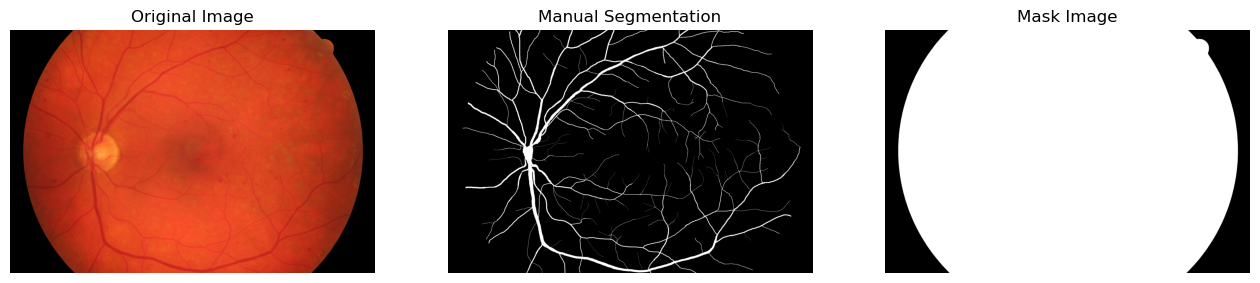

Szerokość obrazu: 3504
Wysokość obrazu: 2336
Szerokość obrazu maski: 3504
Wysokość obrazu maski: 2336


In [7]:
image_path = 'HRF-database/images/01_dr.JPG'
originalImage = cv2.imread(image_path)

segmentedImage_path = 'HRF-database/manual1/01_dr.tif'
segmentedImage = cv2.imread(segmentedImage_path)

mask_path = 'HRF-database/mask/01_dr_mask.tif'
maskImage = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 12))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
plt.title('Manual Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(maskImage, cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.show()

print("Szerokość obrazu:", originalImage.shape[1])
print("Wysokość obrazu:", originalImage.shape[0])

print("Szerokość obrazu maski:", maskImage.shape[1])
print("Wysokość obrazu maski:", maskImage.shape[0])


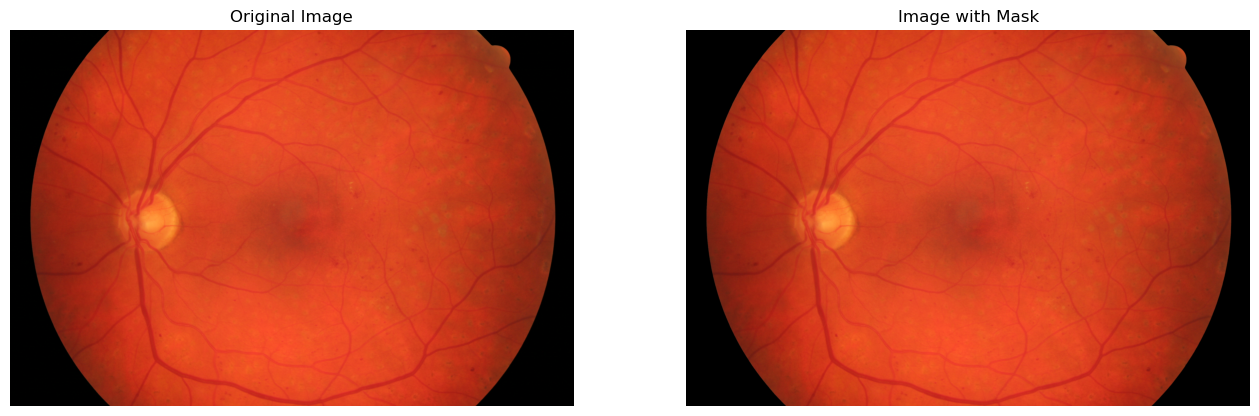

In [57]:
# to fix (usuwanie konturu oka widocznego po segmentacji)
# Perform bitwise AND between the original image and inverted mask to remove pixels outside the eye region
image_with_mask = cv2.bitwise_and(originalImage, originalImage, mask=maskImage)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
plt.title('Image with Mask')
plt.axis('off')

plt.show()

### 1. Przetowrzenie obrazu

- usunięcie tła 

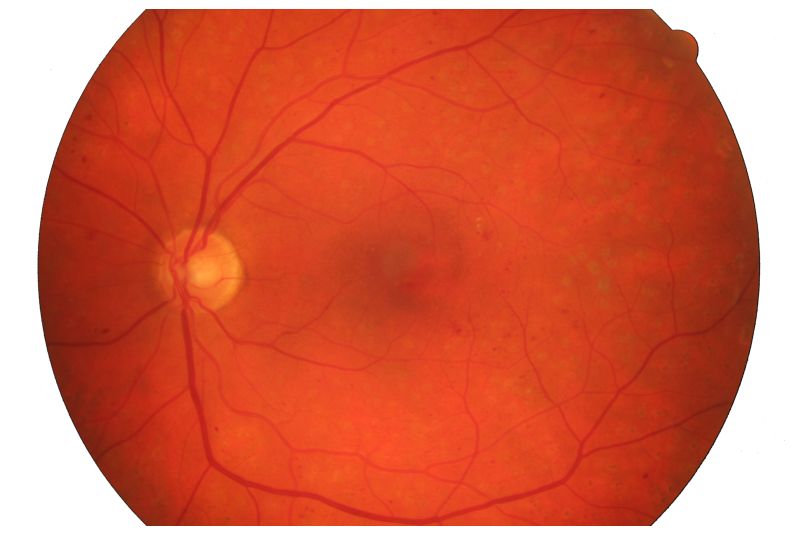

In [58]:
image = image_with_mask.copy()
threshold = 6 # Próg dla każdego kanału kolorów

image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255] # transformacja

show_image(image)

- filtr Gamma

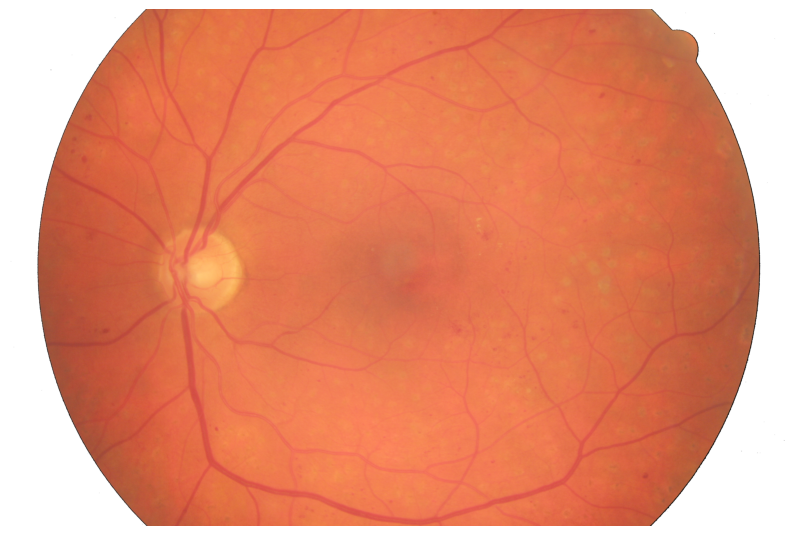

In [59]:
gamma = 1.75
gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
show_image(gamma_corrected_image)

- Konwersja do skali szarości

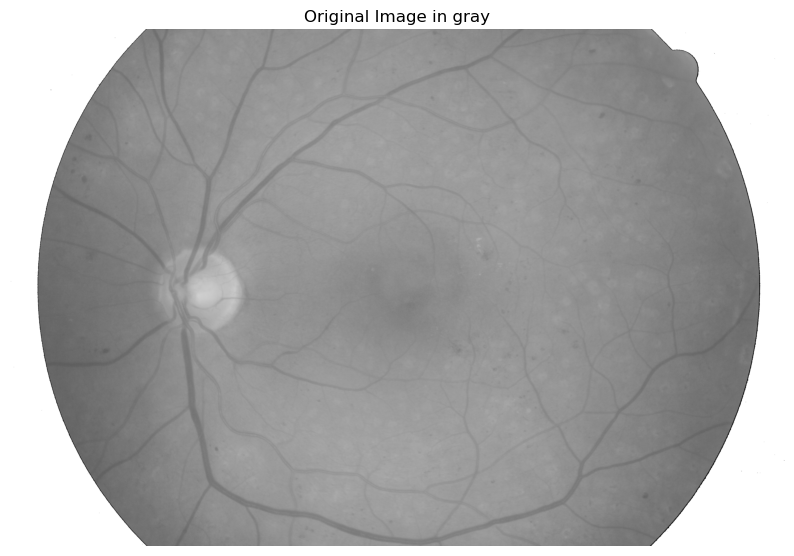

In [60]:
gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)
show_image(gray, title='Original Image in gray')

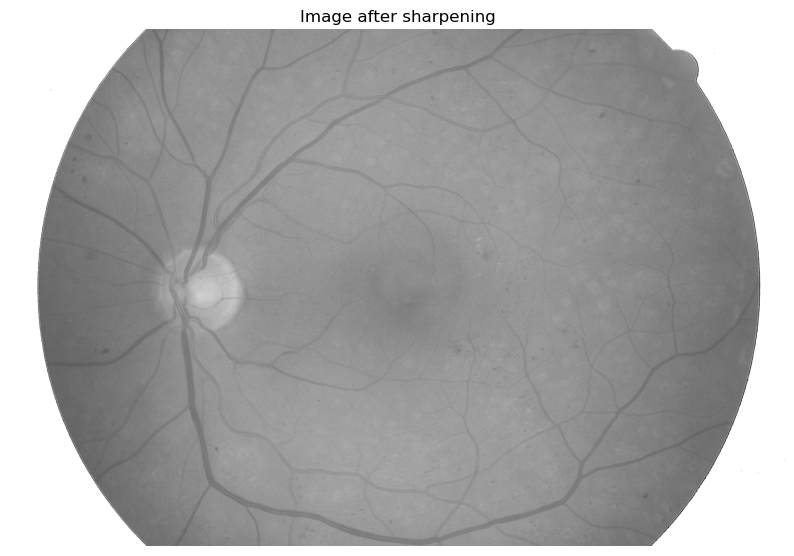

In [61]:
# Wyostrzenie obrazu
sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
show_image(sharp_image, title='Image after sharpening')

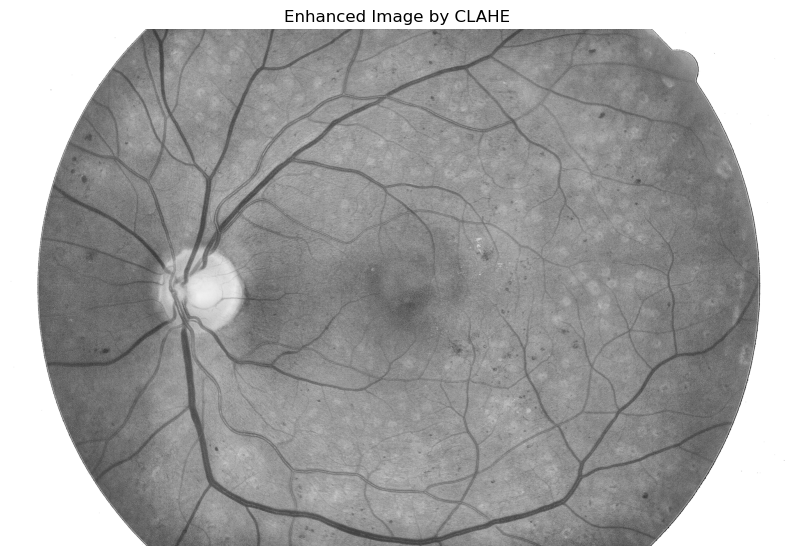

In [62]:
# Zwiększenie kontrastu
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(sharp_image)
show_image(enhanced_image, title='Enhanced Image by CLAHE') # Contrast Limited Adaptive Histogram Equalization

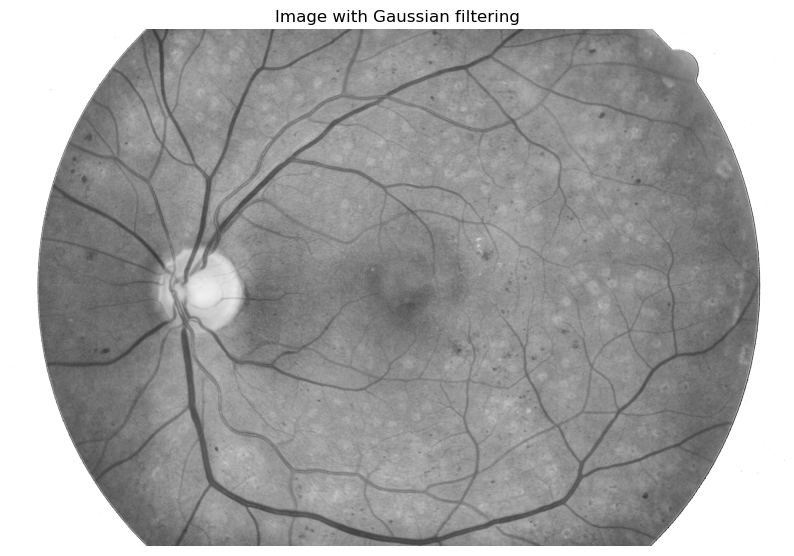

In [66]:
# Filtr bilateralny
bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
show_image(bilateralFiltered, title='Image with Gaussian filtering')

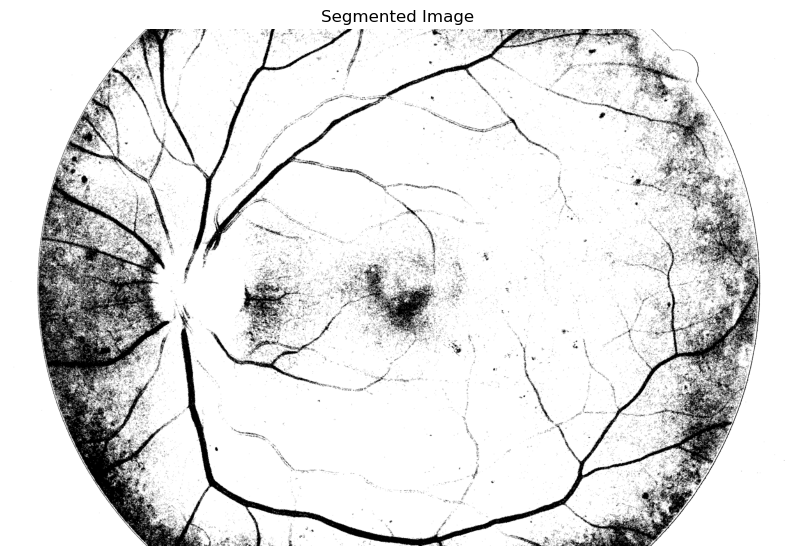

In [67]:
threshold_value = 110 # Ustalenie progu

_, segmented_image = cv2.threshold(bilateralFiltered, threshold_value, 255, cv2.THRESH_BINARY) # segmentacja poprzez progowanie

show_image(segmented_image, title='Segmented Image')

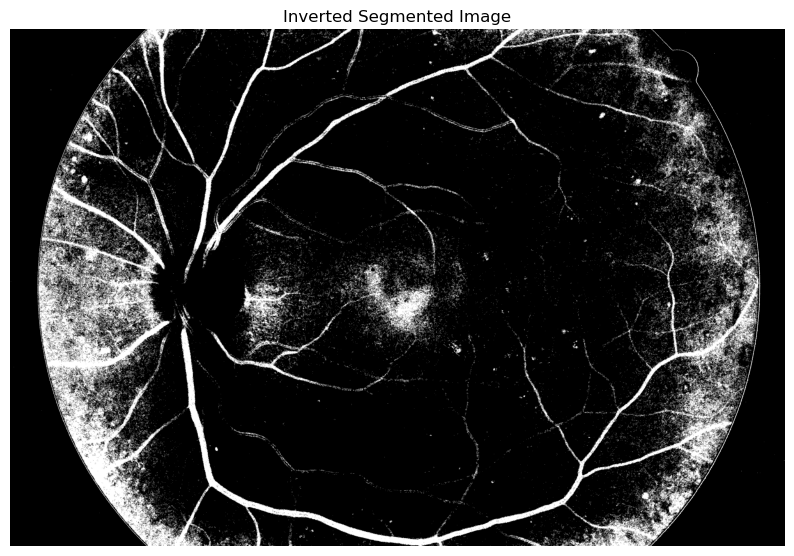

In [68]:
# Odwrócenie kolorów
inverted_segmented_image = 255 - segmented_image
show_image(inverted_segmented_image, title='Inverted Segmented Image')

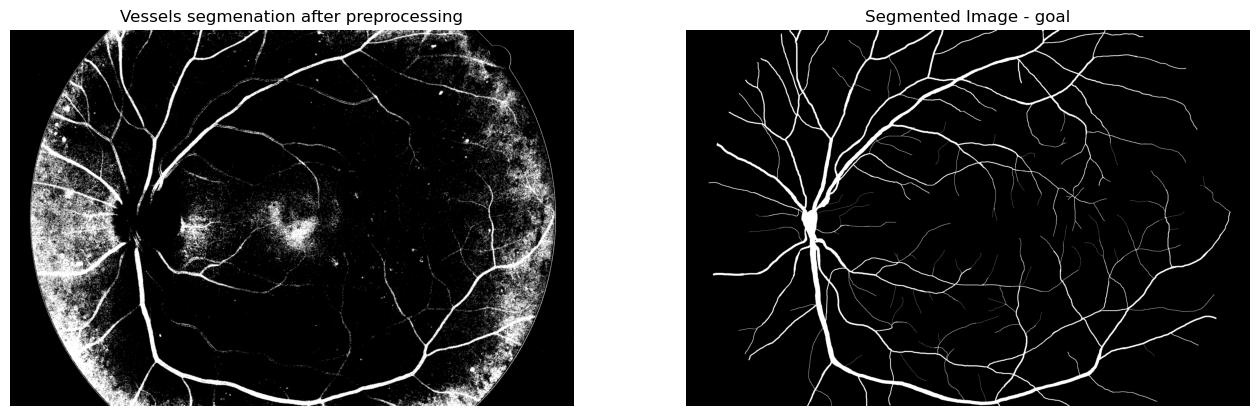

Inverted Segmented Image:
  White pixels: 1041726
  Black pixels: 7143618

Expert's segmented Image (tif_array):
  White pixels: 416282
  Black pixels: 7769062


In [69]:
tif_image_path = "HRF-database/manual1/01_dr.tif"
tif_image = Image.open(tif_image_path)

# Konwersja obrazu PIL do numpy array
tif_array = np.array(tif_image)

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(inverted_segmented_image, cmap='gray')
plt.title('Vessels segmenation after preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tif_array, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

white_pixels_inv_seg = np.sum(inverted_segmented_image == 255)
black_pixels_inv_seg = np.sum(inverted_segmented_image == 0)

white_pixels_tif = np.sum(tif_array == 255)
black_pixels_tif = np.sum(tif_array == 0)

print("Inverted Segmented Image:")
print(f"  White pixels: {white_pixels_inv_seg}")
print(f"  Black pixels: {black_pixels_inv_seg}")

print("\nExpert's segmented Image (tif_array):")
print(f"  White pixels: {white_pixels_tif}")
print(f"  Black pixels: {black_pixels_tif}")

### 2. Ekstrakcja cech + klasyfikator do porównań z CNN (DT / kNN / RF / MLP)

In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
import csv
import seaborn as sns
import matplotlib.pyplot as plt

- Funkcja do ekstrakcji cech dla piksela i jego otoczenia

In [3]:
def extract_features(image, i, j):
    # Pixel
    pixel_value = image[i, j]

    # Patch 4x4
    patch = image[i-1:i+3, j-1:j+3]

    # features: jasność, średnia z otoczenia, odchylenie standardowe, kontrast
    features = [np.mean(pixel_value), np.mean(patch), np.std(patch)]

    # Grayscale patch and contrast
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    features.append(contrast)

    return features

In [5]:
images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

for filename in os.listdir(images_path):
    # original image
    if filename.endswith('.JPG') or  filename.endswith('.jpg'):
        original_image = cv2.imread(os.path.join(images_path, filename))
        original_images.append(original_image)

for filename in os.listdir(segmented_images_path):
    # segmented image
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        
        if segmented_image is not None:
            segmentation_images.append(segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

print(len(original_images))
print(len(segmentation_images))

45
45


In [6]:
features_list = []
labels_list = []

step_size = 5

for original_image, segmentation_image in tqdm(zip(original_images, segmentation_images), total=len(original_images)):
    black_pixel_counter = 0  # Counter for black pixels encountered

    # Iterating through pixels
    for i in range(1, original_image.shape[0]-1, step_size):
        for j in range(1, original_image.shape[1]-1, step_size):
            # Label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            if label == 0:
                black_pixel_counter += 1
                if black_pixel_counter % 5 != 0:  # Consider only pixels where remainder is not 0 (every 5th)
                    continue

            # Feature extraction 
            features = extract_features(original_image, i, j)
            features_list.append(features)
            labels_list.append(label)

    # Reset counter after processing each image
    black_pixel_counter = 0

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [35:33<00:00, 47.41s/it]


In [9]:
with open('features_and_labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(features_list)

In [10]:
# Normalizing features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_list)

- Dataset

In [11]:
X = np.array(X_normalized)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Decision Tree Classifier

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84    544378
           1       0.66      0.28      0.39    226540

    accuracy                           0.74    770918
   macro avg       0.71      0.61      0.61    770918
weighted avg       0.73      0.74      0.71    770918

Drzewo decyzyjne:


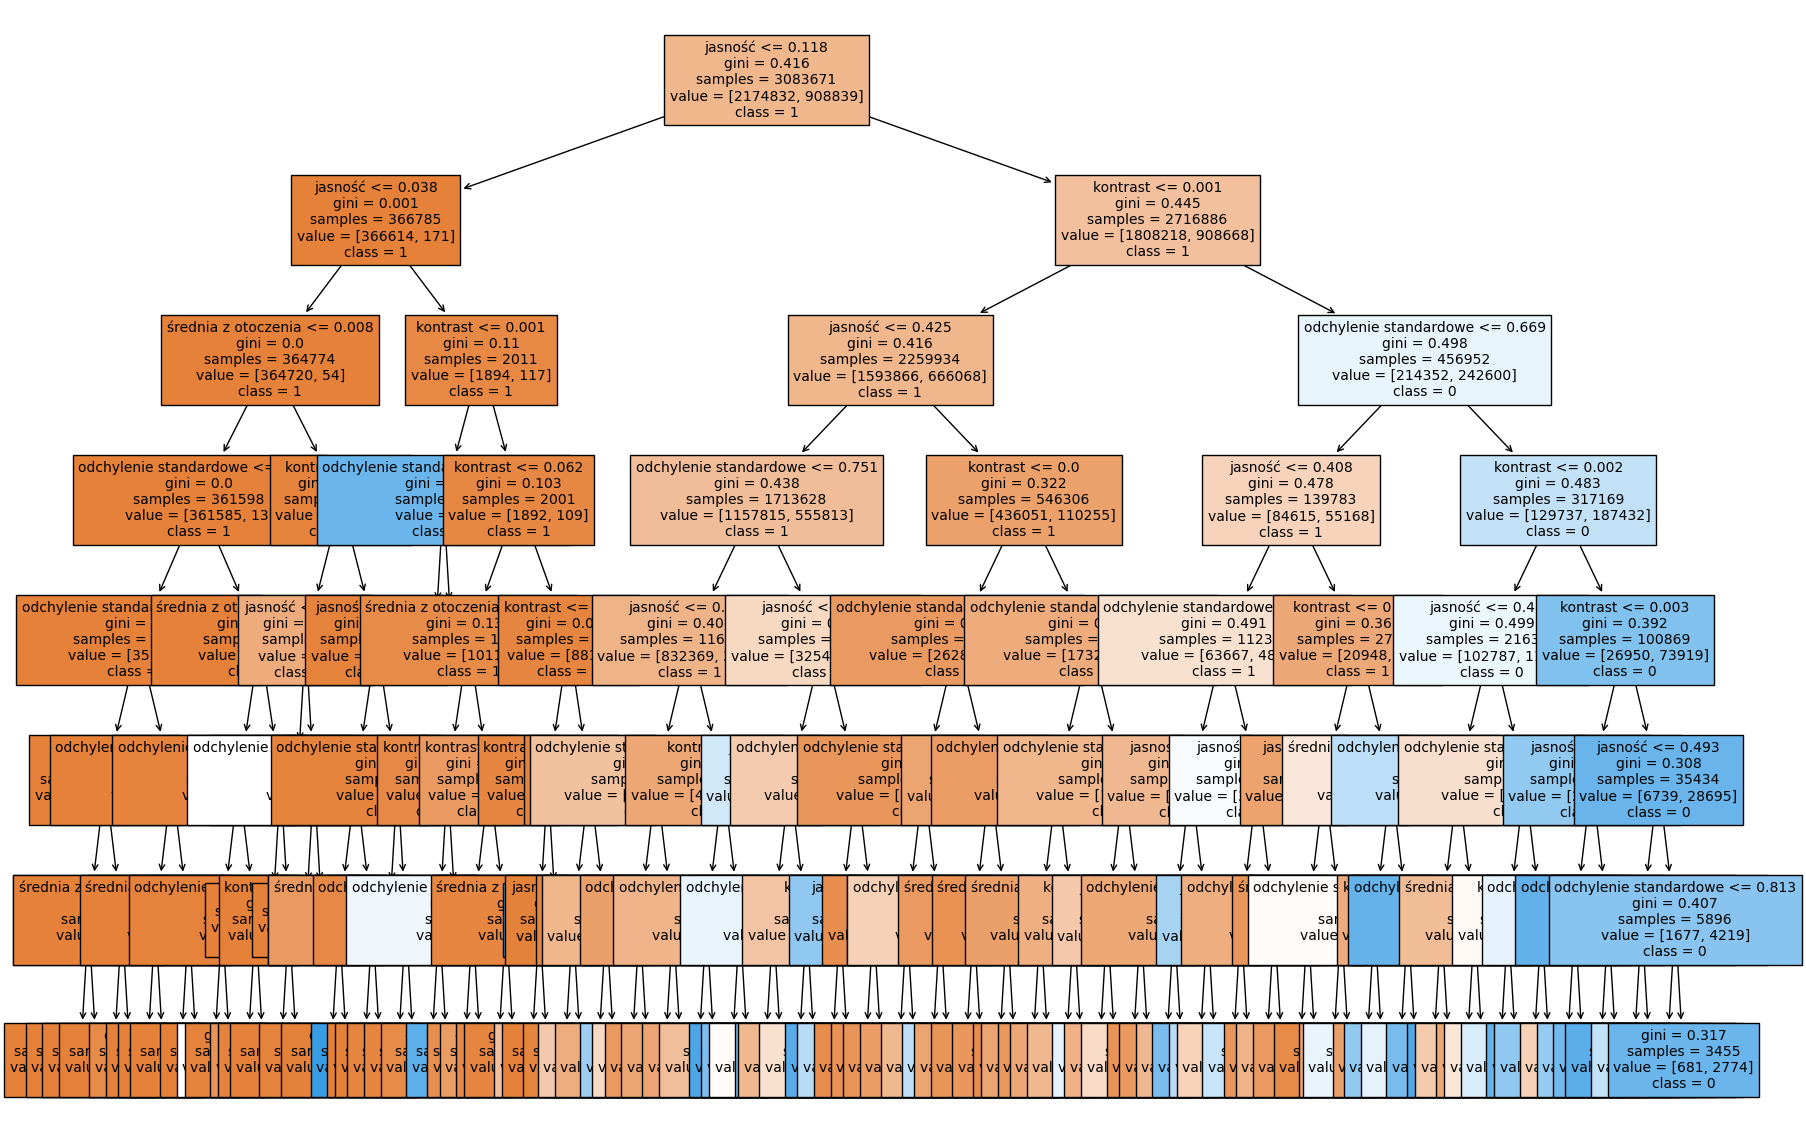

In [40]:
classifier = DecisionTreeClassifier(max_depth=7, criterion = 'gini', random_state=42)

classifier.fit(X_train, y_train)

fig_size = (18, 14)
font_size = 10

feature_names = ['jasność', 'średnia z otoczenia', 'odchylenie standardowe', 'kontrast']

plt.figure(figsize=fig_size)
plot_tree(classifier, 
          feature_names=feature_names,
          class_names=['1', '0'], 
          filled=True, proportion=False, fontsize=font_size)

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)

print("Decision Tree Classification Report:")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

print("Drzewo decyzyjne:")
plt.show()

- RandomForestClassifier

In [79]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

print("Random Forest Classification Report:")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83    544378
           1       0.59      0.41      0.49    226540

    accuracy                           0.74    770918
   macro avg       0.69      0.65      0.66    770918
weighted avg       0.73      0.74      0.73    770918



- K-Nearest Neighbors

In [43]:
classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='auto')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred))

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82    544378
           1       0.55      0.38      0.45    226540

    accuracy                           0.73    770918
   macro avg       0.66      0.62      0.63    770918
weighted avg       0.70      0.73      0.71    770918



- The multilayer perceptron (MLP)

In [53]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84    544378
           1       0.63      0.44      0.52    226540

    accuracy                           0.76    770918
   macro avg       0.71      0.67      0.68    770918
weighted avg       0.75      0.76      0.75    770918



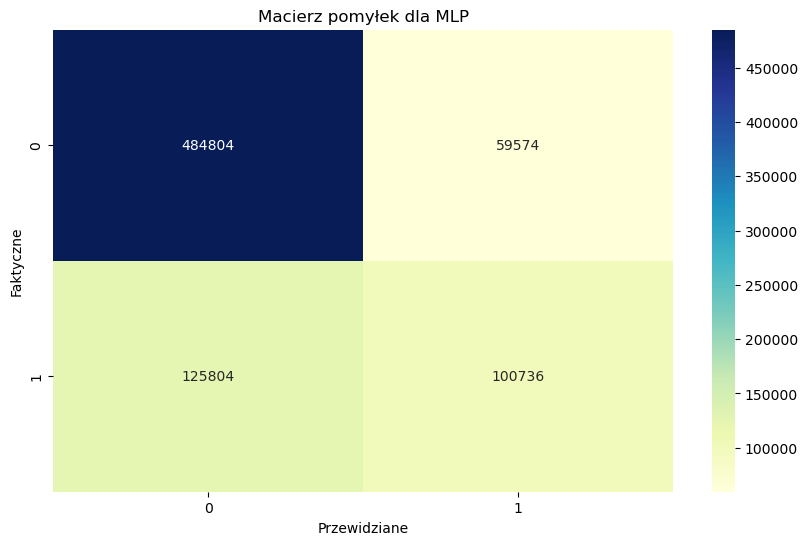

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.title("Macierz pomyłek dla MLP")
plt.xlabel("Przewidziane")
plt.ylabel("Faktyczne")
plt.show()

- model MLP dla obrazu po processingu: 

In [14]:
def process_raw_images(images_path, processed_images_path):
    processed_images = []
    for file in os.listdir(images_path):
        # original image
        if file.endswith('.JPG') or  file.endswith('.jpg'):
            original_image = cv2.imread(os.path.join(images_path, file))
            image = original_image.copy()
            
            # backgrounnd 
            threshold = 6 # Próg dla każdego kanału kolorów
            image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255]
            
            # gamma filter
            gamma = 1.75
            gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
            
            # to gray
            gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)

            # sharpening
            sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
            
            # CLAHE
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            enhanced_image = clahe.apply(sharp_image)
            
            # Filtr bilateralny
            bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
            
            # Save processed image
            processed_images.append(bilateralFiltered)
            cv2.imwrite(os.path.join(processed_images_path, file), bilateralFiltered)

In [15]:
images_path = 'HRF-database/images/'
processed_images_path = 'HRF-database/processed_images/'

process_raw_images(images_path, processed_images_path)

In [16]:
processed_images_path = 'HRF-database/processed_images/'
segmented_images_path = 'HRF-database/manual1/'

processed_images = []
segmentation_images = []

for filename in os.listdir(processed_images_path):
    # original image
    if filename.endswith('.JPG') or  filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(processed_images_path, filename))
        processed_images.append(img)

for filename in os.listdir(segmented_images_path):
    # segmented image
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        
        if segmented_image is not None:
            segmentation_images.append(segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

print(len(processed_images))
print(len(segmentation_images))

45
45


In [17]:
features_list_processed = []
labels_list = []

step_size = 5

for processed_img, segmentation_image in tqdm(zip(processed_images, segmentation_images), total=len(processed_images)):
    black_pixel_counter = 0  # Counter for black pixels encountered

    # Iterating through pixels
    for i in range(1, processed_img.shape[0]-1, step_size):
        for j in range(1, processed_img.shape[1]-1, step_size):
            # Label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            if label == 0:
                black_pixel_counter += 1
                if black_pixel_counter % 5 != 0:  # Consider only pixels where remainder is not 0 (every 5th)
                    continue

            # Feature extraction 
            features = extract_features(processed_img, i, j)
            features_list_processed.append(features)
            labels_list.append(label)

    # Reset counter after processing each image
    black_pixel_counter = 0

100%|██████████| 45/45 [35:05<00:00, 46.79s/it]


In [18]:
# Normalizing features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_list_processed)

In [19]:
# Dataset
X = np.array(X_normalized)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87    544378
           1       0.72      0.60      0.66    226540

    accuracy                           0.82    770918
   macro avg       0.78      0.75      0.76    770918
weighted avg       0.81      0.82      0.81    770918



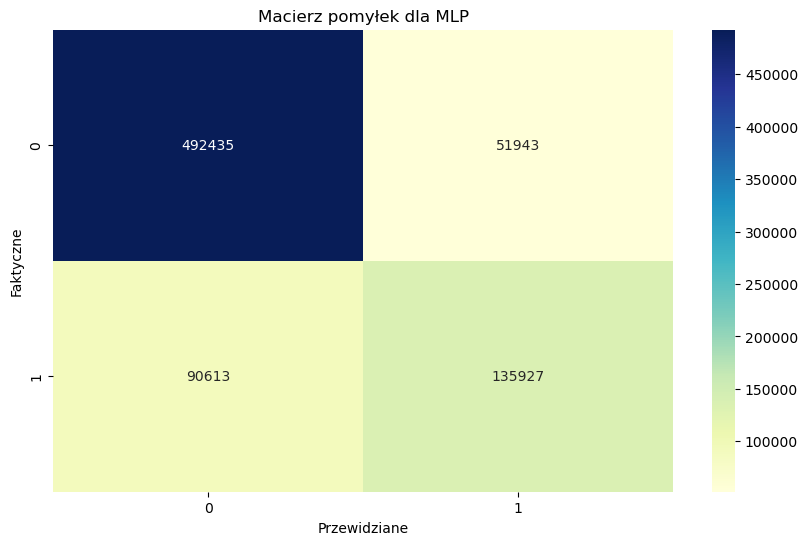

In [20]:
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000, random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.title("Macierz pomyłek dla MLP")
plt.xlabel("Przewidziane")
plt.ylabel("Faktyczne")
plt.show()

### 3. Model głębokiej konwolucyjnej sieci neuronowej

- U-Net architecture:

In [87]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose

class UNet(keras.Model):

    def __init__(self, input_shape=(None, None, 3)):
        super(UNet, self).__init__()

        # Encoder
        inputs = Input(input_shape)
        conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
        conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)  
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        # bottleneck
        conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
        conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
        conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)  

        # Decoder
        up1 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)
        conv3 = Conv2D(32, 3, activation='relu', padding='same')(up1)
        conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
        conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)
        conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)  
        outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

        self.model = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs):
        return self.model(inputs)


- dataset:

In [88]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

# 25% of original
target_height = 584
target_width = 876

# Wczytaj obrazy oryginalne i obrazy segmentacji
for filename in os.listdir(images_path):
    if filename.endswith('.JPG') or filename.endswith('.jpg'):
        original_image = cv2.imread(os.path.join(images_path, filename))
        if original_image is not None:
            resized_image = cv2.resize(original_image, (target_width, target_height))
            original_images.append(resized_image)
        else:
            print(f"Error loading image: {filename}")

for filename in os.listdir(segmented_images_path):
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        if segmented_image is not None:
            resized_segmented_image = cv2.resize(segmented_image, (target_width, target_height))
            segmentation_images.append(resized_segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

X_train, X_val, y_train, y_val = train_test_split(original_images, segmentation_images, test_size=0.2, random_state=42)

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255

# Dodanie wymiaru kanału dla binarnych etykiet (maski segmentacji)
y_train = np.expand_dims(y_train, axis=-1) / 255
y_val = np.expand_dims(y_val, axis=-1) / 255

print("Liczba obrazów treningowych:", len(X_train))
print("Liczba obrazów walidacyjnych:", len(X_val))

Liczba obrazów treningowych: 36
Liczba obrazów walidacyjnych: 9


In [89]:
pred_image = y_val[0]  # Get the first predicted image
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(y_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 0.0
Maximum value: 1.0
Format obrazów w y_pred: (584, 876, 1)


In [90]:
pred_image = X_val[0]  # Get the first predicted image
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(X_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 0.0
Maximum value: 0.9803921568627451
Format obrazów w y_pred: (584, 876, 3)


- training:

In [91]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "u_net_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ ?                      │       203,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
from numba import jit, cuda 

#tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)
#@jit(target_backend=cuda) 
def trainCNN():
     model.fit(X_train, y_train, batch_size=6, epochs=30) #callbacks=[tensorboard_callback])
       
trainCNN()

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.5996 - loss: 0.6429
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.9131 - loss: 0.4171
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.9127 - loss: 0.3449
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.9119 - loss: 0.3080
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 65s 11s/step - accuracy: 0.9095 - loss: 0.2790
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9157 - loss: 0.2491
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.9148 - loss: 0.2538
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9116 - loss: 0.2585
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9101 - loss: 0.2611
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 8s/step - accuracy: 0.9122 - loss: 0.2535
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 9s/step - accuracy: 0.9124 - loss: 0.2506
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 228s 44s/step - accuracy: 0.9151 - loss: 0.2467
Epoch 13/3

In [93]:
model.save('model_segmentingVessels.keras')

In [ ]:
import tensorflow as tf

trained_model = tf.keras.models.load_model('model_segmentingVessels.keras')

- prediction:

In [94]:
# Predykcja naczyń krwionośnych
y_pred = model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [95]:
pred_image = y_pred[0]  
print("Minimum value:", np.min(pred_image))
print("Maximum value:", np.max(pred_image))
image_shape = np.shape(y_val[0])
print("Format obrazów w y_pred:", image_shape)

Minimum value: 3.0207662e-08
Maximum value: 0.97989047
Format obrazów w y_pred: (584, 876, 1)


In [96]:
image_shape = np.shape(y_pred[0])
print("Format obrazów w y_pred:", image_shape)
image_shape = np.shape(X_val[0])
print("Format obrazów w X_val:", image_shape)

Format obrazów w y_pred: (584, 876, 1)
Format obrazów w X_val: (584, 876, 3)


In [101]:
import numpy as np

def binary_mask(image, threshold):
    binary_image = np.where(image >= threshold, 1, 0)
    return binary_image

# Wartość progu
threshold_value = 0.5 
binary_mask_image = binary_mask(y_pred[0], threshold_value)
#print(binary_mask_image)

In [102]:
white_pixels = np.count_nonzero(binary_mask_image)
black_pixels = np.prod(binary_mask_image.shape) - white_pixels

print("Liczba pikseli o wartości 1 (białych):", white_pixels)
print("Liczba pikseli o wartości 0 (czarnych):", black_pixels)


Liczba pikseli o wartości 1 (białych): 13988
Liczba pikseli o wartości 0 (czarnych): 497596


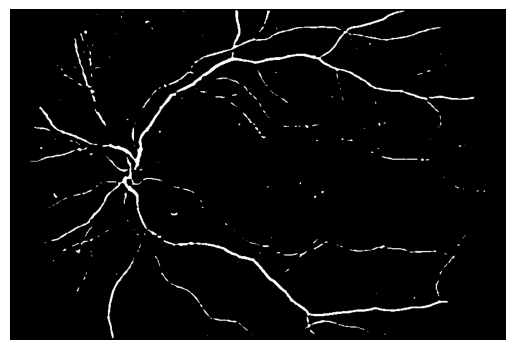

In [103]:
import matplotlib.pyplot as plt

# Wyświetlanie binarnej maski jako obrazu
plt.imshow(binary_mask_image[:,:,0], cmap='gray')  # Wyświetlenie pierwszego kanału
plt.axis('off') 
plt.show()

In [100]:
cv2.imshow("Obraz X_val[0]", y_pred[0])
cv2.waitKey(0)  # Wait for user input before closing the window
cv2.destroyAllWindows()

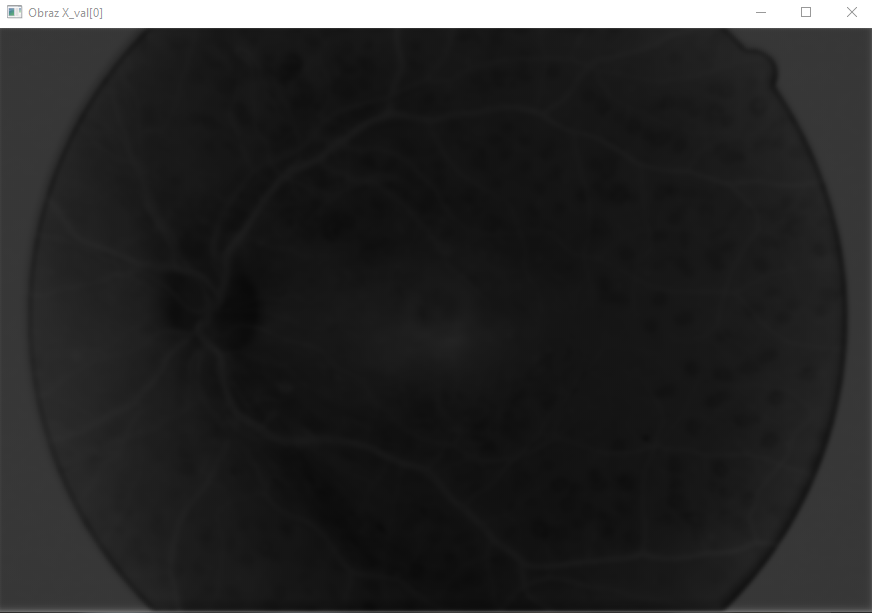

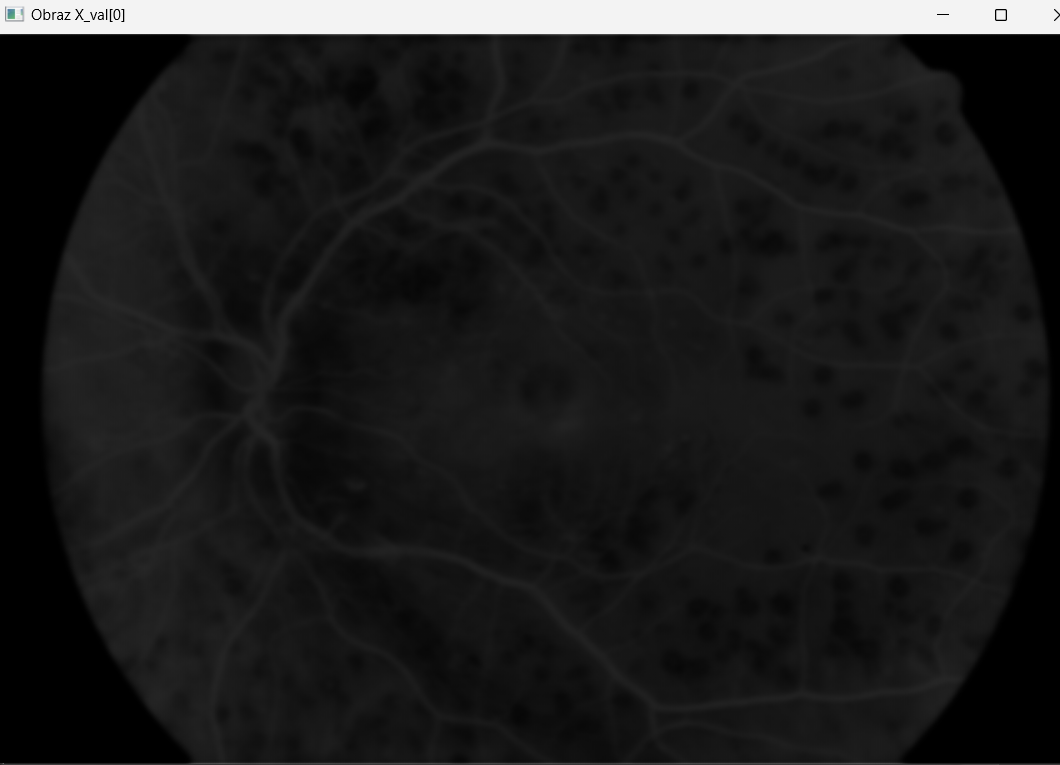

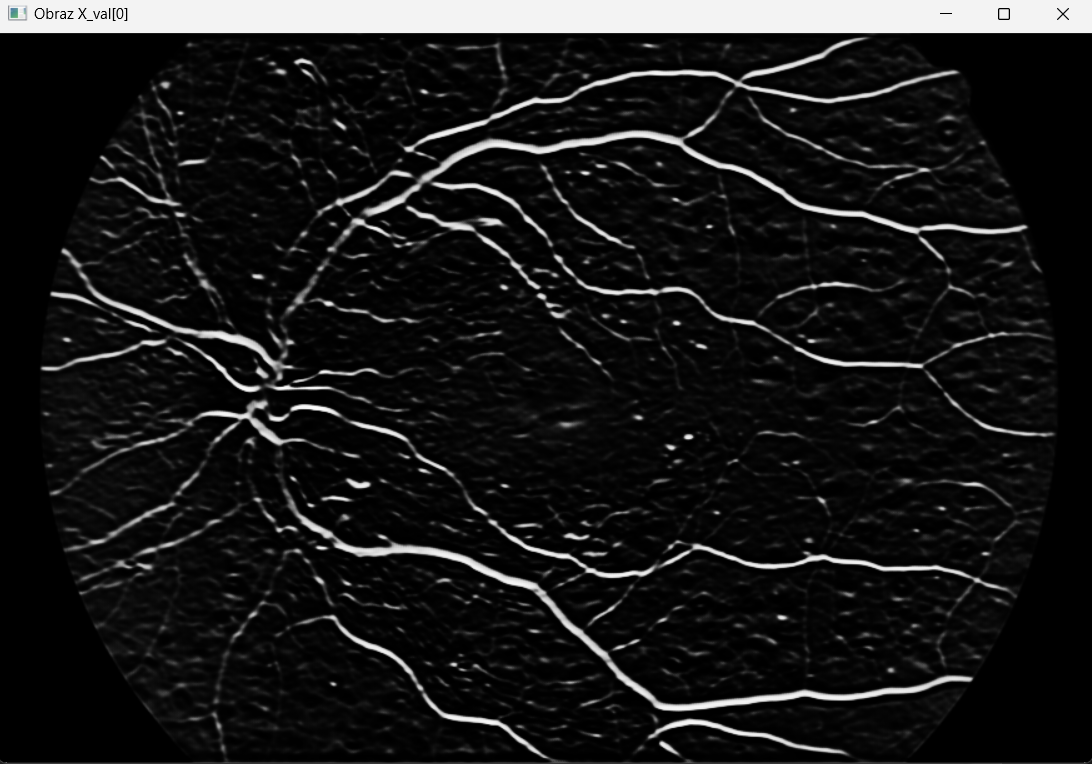

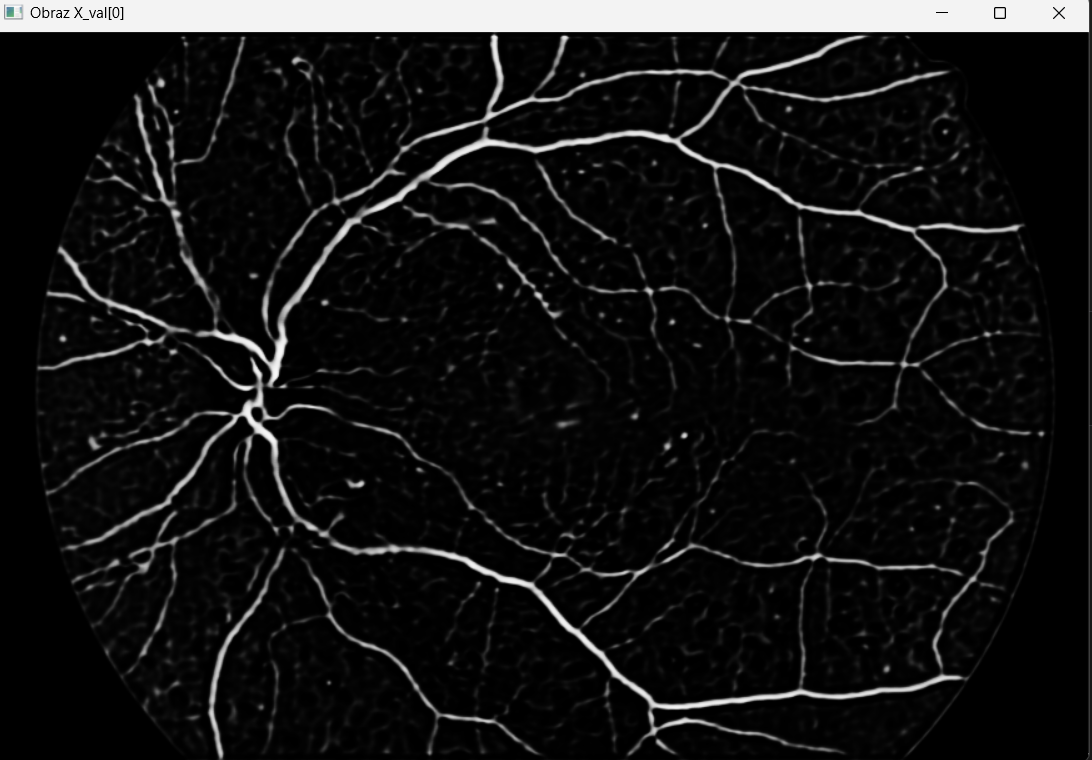

- prediction & metrics functions

In [110]:
# Zastosowanie progu do binarnej segmentacji
def apply_threshold(pred, threshold=0.5):
  pred_bin = np.round(pred) > threshold
  return pred_bin

# Obliczenie metryk klasyfikacji binarnej
def compare_pred_mask(pred, mask):
  # Konwersja predykcji i maski do formatu binarnego
  pred_bin = pred
  mask_bin = mask

  tp = np.sum(pred_bin * mask_bin)
  tn = np.sum((1 - pred_bin) * (1 - mask_bin))
  fp = np.sum(pred_bin * (1 - mask_bin))
  fn = np.sum((1 - pred_bin) * mask_bin)

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

- model evaluation:

In [111]:
# Obliczenie metryk dla każdego obrazu w zbiorze walidacyjnym
metrics_per_image = []
for i in range(len(X_val)):
  pred = y_pred[i][:, :, 0]
  mask = y_val[i][:, :, 0]

  # Zastosowanie progu
  pred_bin = apply_threshold(pred)

  # Obliczenie metryk
  metrics_per_image.append(compare_pred_mask(pred_bin, mask))

# średnie metryk
metrics_avg = {metric: np.mean([m[metric] for m in metrics_per_image]) for metric in metrics_per_image[0]}

# Wyświetlenie metryk
print("Metryki klasyfikacji:")
for metric, value in metrics_avg.items():
  print(f"{metric}: {value:.4f}")

Metryki klasyfikacji:
accuracy: 0.9522
precision: 0.8532
recall: 0.4959
f1_score: 0.6210


### 4. Wyniki dla przykładowych instancji